In [540]:
import shutil
import networkx as nx
import dgl
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


In [541]:
import polygraphs as pg
from polygraphs import hyperparameters as hparams
from polygraphs import ops
from polygraphs.ops import math, complex
from polygraphs.analysis import Processor

In [527]:
def complete(size, seed=None):
    """
    Create a PolyGraph configuration for a complete network
    """
    params = hparams.PolyGraphHyperParameters()

    # Initial beliefs are random uniform between 0 and 1
    params.init.kind = 'uniform'
    # Chance that action B is better than action A
    params.epsilon = 0.001

    params.network.kind = 'complete'
    params.network.size = size

    params.simulation.steps = 10000
    params.logging.enabled = False

    # Take snapshots (incl. messages)
    params.snapshots.enabled = True
    params.snapshots.interval = 100
    params.snapshots.messages = True

    # Set seed
    pg.random()

    if seed:
        # Explicitly set seed
        params.seed = seed
        pg.random(params.seed)

    return params

In [ ]:
# Delete existing data folder for results
try:
    shutil.rmtree("data")
except:
    pass

In [528]:
# BalaGoyal
params = complete(1000, seed=12345)
params.simulation.results = "data/bg"
_ = pg.simulate(params, op=ops.BalaGoyalOp)

 INFO polygraphs> Sim #0001:    207 steps   13.15s; action: B undefined: 0 converged: 1 polarized: 0 


Modifying OconnorWeatherall from common.py


In [309]:
class OConnorWeatherallOp(ops.core.PolyGraphOp):
    """
    Scientific polarisation (O'Connor & Weatherall, 2018)
    """

    def __init__(self, graph, params):
        super().__init__(graph, params)

        # Multiplier that captures how quickly agents become uncertain about
        # the evidence of their peers as their beliefs diverge.
        self.mistrust = params.mistrust

        # Whether to discount evidence with unti-updating or not
        self.antiupdating = params.antiupdating

    def filterfn(self):
        """
        # Filters out edges whose source has no evidence to report
        """

        def function(edges):
            return torch.gt(edges.src["payoffs"][:, 1], 0.0)

        return function

    def messagefn(self):
        """
        Message function
        """

        def function(edges):
            return {"payoffs": edges.src["payoffs"], "beliefs": edges.src["beliefs"]}

        return function

    def _distancefn(self, delta):
        """
        Distance function
        """
        return delta * self.mistrust

    def reducefn(self):
        """
        Reduce function
        """

        def function(nodes):
            # Log probability of successful trials
            logits = nodes.data["logits"]
            # Prior, P(H) (aka. belief)
            prior = nodes.data["beliefs"]

            attrs = vars(nodes)
            print(', '.join("%s: %s" % item for item in attrs.items()))
            # Number of nodes and number of neighbours per node (incoming messages)
            _, neighbours = nodes.mailbox["beliefs"].shape
            for i in range(neighbours):
                # A node receives evidence E from its i-th neighbour, say Jill,
                # denoting the number of successful trials and the total number
                # of trials she observed
                values = nodes.mailbox["payoffs"][:, i, 0]
                trials = nodes.mailbox["payoffs"][:, i, 1]

                # Evidence, E
                evidence = math.Evidence(logits, values, trials)

                # The difference in belief between an agent
                # and its i-th neighbour
                delta = torch.abs(prior - nodes.mailbox["beliefs"][:, i])

                # Compute belief that the evidence E is real, P(E)(d)
                if self.antiupdating:
                    certainty = torch.max(
                        1.0
                        - self._distancefn(delta)
                        * (1.0 - math.marginal(prior, evidence)),
                        torch.zeros((len(nodes),)),
                    )
                else:
                    # Consider an agent u and one of its neighbours, v. As
                    # beliefs between u and v diverge (delta towards 1),
                    # agent u simply ignores the evidence of agent v.
                    #
                    # If delta becomes 1, uncertainty ~ marginal. In other
                    # words, agent u's belief remains unchanged in light of
                    # agent v's evidence.
                    #
                    # The multiplier simply determines how far apart beliefs
                    # have to become before agent u begins to ignore the
                    # evidence of its neighbour, v (since delta never becomes 1)
                    certainty = 1.0 - torch.min(
                        torch.ones((len(nodes),)), self._distancefn(delta)
                    ) * (1.0 - math.marginal(prior, evidence))

                # Compute posterior belief, in light of soft uncertainty
                posterior = math.jeffrey(prior, evidence, certainty)

                # Consider next neighbour
                prior = posterior

            # Return posterior beliefs for each neighbour
            return {"beliefs": posterior}

        return function

In [310]:
# Delete existing data folder for results
try:
    shutil.rmtree("data")
except:
    pass

params = complete(16, seed=12345)
params.simulation.results = "data/ow"
_ = pg.simulate(params, op=OConnorWeatherallOp)

KeyboardInterrupt: 

## Analysis


In [529]:
x = Processor("data")

In [530]:
x.get()

,bin_file_path,hd5_file_path,config_json_path,trials,network_size,network_kind,op,epsilon,steps,duration,action,undefined,converged,polarized
0,data/ow/1.bin,data/ow/1.hd5,data/ow/configuration.json,10.0,1000.0,complete_grouped,Epistemic_Injustice,0.001,219.0,17.762682,B,False,True,False
1,data/bg/1.bin,data/bg/1.hd5,data/bg/configuration.json,10.0,1000.0,complete,BalaGoyalOp,0.001,207.0,13.152652,B,False,True,False


<Axes: xlabel='iteration'>

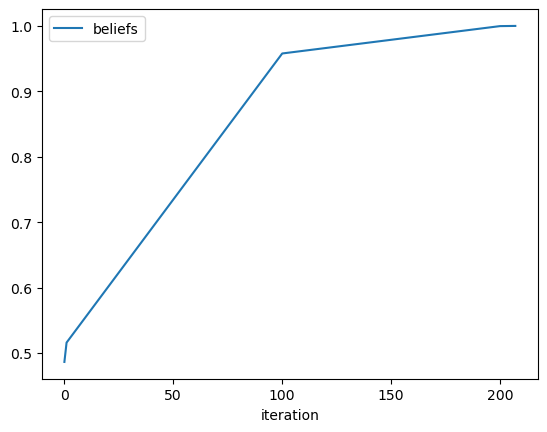

In [532]:

x.beliefs[1].groupby("iteration").mean().plot()

<Axes: xlabel='iteration'>

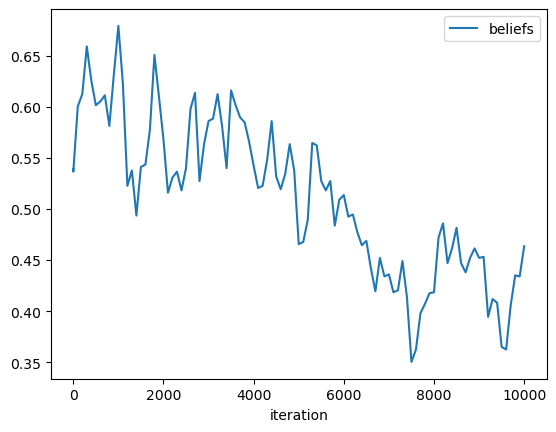

In [272]:
#x.beliefs[1].groupby("iteration").mean().plot()
x.beliefs[0].groupby("iteration").mean().plot()

# Original Aligned

In [ ]:
class AlignedOp(complex.UnreliableOp):
    """
    Baseclass for Aligned Ops that uses Jeffreys rule

    Unreliable networks, Part 2

    There are two types of nodes, reliable and unreliable ones.

    Upon receipt, all nodes apply Jeffrey's rule.
    """

    def __init__(self, graph, params):
        super().__init__(graph, params)
        # Store network reliability in the graph
        graph.ndata["reliability"] = self._reliability.to(device=self._device)

    def messagefn(self):
        """
        Message function
        """

        def function(edges):
            return {
                "payoffs": edges.src["payoffs"],
                "reliability": edges.src["reliability"],
            }

        return function

    def reducefn(self):
        """
        Reduce function
        """

        def function(nodes):
            # Log probability of successful trials
            logits = nodes.data["logits"]
            # Prior, P(H) (aka. belief)
            prior = nodes.data["beliefs"]

            # Number of nodes and number of neighbours per node (incoming messages)
            _, neighbours = nodes.mailbox["reliability"].shape
            for i in range(neighbours):
                # A node receives evidence E from its i-th neighbour, say Jill,
                # denoting the number of successful trials and the total number
                # of trials she observed
                values = nodes.mailbox["payoffs"][:, i, 0]
                trials = nodes.mailbox["payoffs"][:, i, 1]

                # Evidence, E
                evidence = math.Evidence(logits, values, trials)

                # Get i-th neighbour reliability
                reliability = nodes.mailbox["reliability"][:, i]

                # log.info(f"Neighbour {i:2d}: reliability {reliability}")

                # Compute posterior belief, in light of soft uncertainty
                # (i.e., network unreliability)
                posterior = math.jeffrey(prior, evidence, reliability)

                # Consider next neighbour
                prior = posterior

            # Return posterior beliefs for each neighbour
            return {"beliefs": posterior}

        return function

In [ ]:
params = complete(16, seed=12345)
params.simulation.results = "data/ow"
_ = pg.simulate(params, op=AlignedOp)

# Iteration

In [615]:
def prejudice_params(size, groups, prejudiced_certainty, non_prejudiced_certainty, seed=None):
    """
    Create a PolyGraph configuration for a grouped complete network
    """
    params = hparams.PolyGraphHyperParameters()

    # Setting number of groups
    params.network.groups = groups

    # Setting prejudice and non-prejudice certainty for Jeffrey's Rule
    params.mistrust = prejudiced_certainty
    params.trust = non_prejudiced_certainty

    # Initial beliefs are random uniform between 0 and 1
    params.init.kind = 'uniform'
    # Chance that action B is better than action A
    params.epsilon = 0.001

    params.network.kind = 'complete_grouped'
    params.network.size = size

    params.simulation.steps = 1000
    params.logging.enabled = False

    # Take snapshots (incl. messages)
    params.snapshots.enabled = True
    params.snapshots.interval = 100
    params.snapshots.messages = True


    # Set seed
    pg.random()

    if seed:
        # Explicitly set seed
        params.seed = seed
        pg.random(params.seed)

    return params

In [273]:
class Epistemic_Injustice(ops.BalaGoyalOp):
    """
   
    Upon receipt, all nodes apply Jeffrey's rule.
    """

    def __init__(self, graph, params):
        super().__init__(graph, params)
        

        # Define list of unique groups from node features and store as instance attribute
        self.groups = torch.unique(graph.ndata['group']).tolist()

         # Create group masks
        self.group_masks = {}
        for group in self.groups:
            self.group_masks[group] = (graph.ndata['group'] == group)
        # print((graph.ndata['group']))
        # print(self.group_masks[0])

    def messagefn(self):
        """
        Message function
        """

        def function(edges):
            return {
                "payoffs": edges.src["payoffs"],
                "group": edges.src["group"],
            }

        return function

    def reducefn(self):
        """
        Reduce function
        """

        def function(nodes):
            # Log probability of successful trials
            logits = nodes.data["logits"]
            # Prior, P(H) (aka. belief)
            prior = nodes.data["beliefs"]

    
            for recipient_group in self.groups:
                group_mask = self.group_masks[recipient_group]
                
                for sender_group in self.groups:
                    sender_mask = (nodes.mailbox["group"][group_mask] == sender_group)
                    # print(f"sender group {sender_group}")
                    # print(nodes.mailbox["payoffs"][group_mask][sender_mask])

                    sender_group_values = torch.sum(nodes.mailbox["payoffs"][group_mask][sender_mask][:, 0])
                    sender_group_trials = torch.sum(nodes.mailbox["payoffs"][group_mask][sender_mask][:, 1])

                    # Evidence, E
                    evidence = math.Evidence(logits, sender_group_values, sender_group_trials)

                    # Define group 0 as prejudiced-against and group 1 as prejudiced
                    if sender_group == 0 and recipient_group == 1:
                        # Define arbitrary amount of evidence-discounting performed by prejudiced nodes
                        certainty = 0
                    else:
                        certainty = 1
                    
                    # Compute posterior belief
                    posterior = math.jeffrey(prior, evidence, certainty)

                    # Consider next sender group
                    prior = posterior

            # Return posterior beliefs
            return {"beliefs": posterior}

        return function

In [ ]:
# class Epistemic_Injustice_Checkpoint(ops.BalaGoyalOp):
#     """
   
#     Upon receipt, all nodes apply Jeffrey's rule.
#     """

#     def __init__(self, graph, params):
#         super().__init__(graph, params)
        

#         # Define list of unique groups from node features and store as instance attribute
#         self.groups = torch.unique(graph.ndata['group']).tolist()

#          # Create group masks
#         self.group_masks = {}
#         for group in self.groups:
#             self.group_masks[group] = (graph.ndata['group'] == group)
#         # print((graph.ndata['group']))
#         # print(self.group_masks[0])

#     def messagefn(self):
#         """
#         Message function
#         """

#         def function(edges):
#             return {
#                 "payoffs": edges.src["payoffs"],
#                 "group": edges.src["group"],
#             }

#         return function

#     def reducefn(self):
#         """
#         Reduce function
#         """

#         def function(nodes):
#             # Log probability of successful trials
#             logits = nodes.data["logits"]
#             # Prior, P(H) (aka. belief)
#             prior = nodes.data["beliefs"]

    
#             for recipient_group in self.groups:
#                 group_mask = self.group_masks[recipient_group]
                
#                 for sender_group in self.groups:
#                     sender_mask = (nodes.mailbox["group"][group_mask] == sender_group)
#                     # print(f"sender group {sender_group}")
#                     # print(nodes.mailbox["payoffs"][group_mask][sender_mask])

#                     sender_group_values = torch.sum(nodes.mailbox["payoffs"][group_mask][sender_mask][:, 0])
#                     sender_group_trials = torch.sum(nodes.mailbox["payoffs"][group_mask][sender_mask][:, 1])

#                     # Evidence, E
#                     evidence = math.Evidence(logits, sender_group_values, sender_group_trials)

#                     # Define group 0 as prejudiced-against and group 1 as prejudiced
#                     if sender_group == 0 and recipient_group == 1:
#                         # Define arbitrary amount of evidence-discounting performed by prejudiced nodes
#                         certainty = 0
#                     else:
#                         certainty = 1
                    
#                     # Compute posterior belief
#                     posterior = math.jeffrey(prior, evidence, certainty)

#                     # Consider next sender group
#                     prior = posterior

#             # Return posterior beliefs
#             return {"beliefs": posterior}

#         return function

In [613]:
class Epistemic_Injustice(ops.BalaGoyalOp):
    """
   
    Upon receipt, all nodes apply Jeffrey's rule.
    """

    def __init__(self, graph, params):
        super().__init__(graph, params)
        
        # Grabbing list of group labels
        self.groups = torch.unique(graph.ndata['group']).tolist()
        
        # Grabbing certainty value for Jeffrey's Rule where testimonial injustice occurs
        self.default_certainty = params.trust

        # Grabbing certainty values for Jeffrey's Rule where testimonial injustice does not occur
        self.prejudice_amount = params.mistrust

        #  # Create group masks
        # self.group_masks = {}

        # for group in self.groups:
        #     self.group_masks[group] = (graph.ndata['group'] == group)
        # # print((graph.ndata['group']))
        # # print(self.group_masks[0])

    def messagefn(self):
        """
        Message function
        """

        def function(edges):
            return {
                "payoffs": edges.src["payoffs"],
                "group": edges.src["group"],
            }

        return function

    def reducefn(self):
        """
        Reduce function
        """

        def function(nodes):
            # Log probability of successful trials
            logits = nodes.data["logits"]
            # Prior, P(H) (aka. belief)
            prior = nodes.data["beliefs"]
            # Current Node's group
            recipient_group = nodes.data["group"]

            print("Recipients:",recipient_group)
            print("Mailbox group:",nodes.mailbox["group"])
            print("All payoffs:",nodes.mailbox["payoffs"])

            # Duplicate each node's group label across columns for every neighbor
            # recipient_group_expanded = recipient_group.unsqueeze(1).expand(-1, nodes.mailbox["group"].shape[1])

            #print("expanded:",recipient_group_expanded)
            # print("Mailbox Groups")
            #print("mailbox group:",nodes.mailbox["group"])
            # print("mailbox payoffs shape:",nodes.mailbox["payoffs"].shape)
            #print("shape of nodes.data[group]",nodes.data["group"].shape)
            
            default_certainty = self.default_certainty
            prejudice_amount = self.prejudice_amount # Amount of discrediting for instances of testimonial injustice

            for group in self.groups:
                group_mask = (nodes.mailbox["group"] == group)
            
                masked_payoffs = nodes.mailbox["payoffs"] * group_mask.unsqueeze(-1).float()
                
                print("Iterating over group:",group,)
                print("Masked Payoffs:",masked_payoffs)

                    # TOTAL CERTAINTY TENSOR, PROBABLY NOT NEEDED
                    # certainty_bin = (nodes.mailbox["group"] == 0) & (recipient_group_expanded == 1)
                    # #print("certainty",certainty_bin)

                    # # Define inverse mask
                    # certainty_bin_inv = ~certainty_bin
                    # #print("certainty inverse",certainty_bin_inv)

                    # # Set certainty in case of prejudice
                    # prejudiced_certainty = certainty_bin * 0.5 # Amount of discrediting, max: 0, min: 1

                    # # Set certainity for all other cases
                    # non_prejudiced_certainty = certainty_bin_inv * .9
                
                # Define nodes belonging to group 0 as prejudiced-against
                # (The certainty value for instances of testimonial injustice is applied only if the payoffs are sent by group 0)
                if group == 0:

                    # Define nodes belonging to group 1 as prejudiced
                    prejudiced_nodes_mask = (recipient_group == 1)

                    # Define all other nodes as non-prejudiced
                    non_prejudiced_nodes_mask = ~prejudiced_nodes_mask

                    # print(recipient_group)
                    print("Prejudiced nodes:",prejudiced_nodes_mask)
                    # print(non_prejudiced_nodes_mask)

                    # Set certainty in case of prejudice
                    prejudiced_certainty = prejudiced_nodes_mask * prejudice_amount

                    # Set certainity for all other cases
                    non_prejudiced_certainty = non_prejudiced_nodes_mask * default_certainty

                    # Combine certainty tensors
                    certainty = prejudiced_certainty + non_prejudiced_certainty

                    print("Combined certainty:",certainty)

                    # Sum values for all neighbors belonging to current sender group
                    sender_group_values = torch.sum(masked_payoffs[:, :, 0], dim=1)
                    #print("Masked values sum:",sender_group_values)

                    # Sum trials for all neighbors belonging to current sender group
                    sender_group_trials = torch.sum(masked_payoffs[:, :, 1], dim=1)
                    #print("Masked trials sum:",sender_group_trials)

                    # Evidence, E
                    evidence = math.Evidence(logits, sender_group_values, sender_group_trials)
                    print("Evidence:",evidence)

                    # Apply Jeffrey's Rule to all nodes
                    posterior = math.jeffrey(prior, evidence, certainty)

                    # Consider next sender group
                    prior = posterior


                else:

                    # Create a tensor with a 1 for each node in the network 
                    recipient_ones = torch.ones_like(recipient_group)
                    # Multiply 1's by default certainty
                    certainty = recipient_ones * default_certainty
                    print("Combined certainty:",certainty)
                    
                    # Sum values for all neighbors belonging to current sender group
                    sender_group_values = torch.sum(masked_payoffs[:, :, 0], dim=1)
                    #print("masked values sum:",sender_group_values)

                    # Sum trials for all neighbors belonging to current sender group
                    sender_group_trials = torch.sum(masked_payoffs[:, :, 1], dim=1)
                    print("masked trials sum:",sender_group_trials)

                    # Evidence, E
                    evidence = math.Evidence(logits, sender_group_values, sender_group_trials)
                    print("Evidence:",evidence)

                    # Apply Jeffrey's Rule to all nodes
                    posterior = math.jeffrey(prior, evidence, certainty)
                    
                    # Consider next sender group
                    prior = posterior

            # Return posterior beliefs
            return {"beliefs": posterior}

        return function

In [614]:
# Delete existing data folder for results
try:
    shutil.rmtree("data")
except:
    pass

params = prejudice_params(9, 3, .5, 1, seed=12343) #(size, groups, prejudiced_certainty, non_prejudiced_certainty, seed)
params.simulation.results = "data/ow"
_ = pg.simulate(params, op=Epistemic_Injustice)



Recipients: tensor([1, 0, 1, 2, 1, 0, 0, 2, 2])
Mailbox group: tensor([[0, 2, 0, 2, 1],
        [1, 2, 0, 2, 0],
        [1, 0, 2, 0, 2],
        [1, 0, 0, 2, 2],
        [1, 0, 2, 0, 2],
        [1, 0, 2, 0, 2],
        [1, 0, 2, 2, 0],
        [1, 0, 2, 0, 2],
        [1, 0, 2, 0, 2]])
All payoffs: tensor([[[ 4., 10.],
         [ 7., 10.],
         [ 5., 10.],
         [ 4., 10.],
         [ 3., 10.]],

        [[ 3., 10.],
         [ 7., 10.],
         [ 5., 10.],
         [ 4., 10.],
         [ 4., 10.]],

        [[ 3., 10.],
         [ 4., 10.],
         [ 7., 10.],
         [ 5., 10.],
         [ 4., 10.]],

        [[ 3., 10.],
         [ 4., 10.],
         [ 5., 10.],
         [ 4., 10.],
         [ 7., 10.]],

        [[ 3., 10.],
         [ 4., 10.],
         [ 7., 10.],
         [ 5., 10.],
         [ 4., 10.]],

        [[ 3., 10.],
         [ 4., 10.],
         [ 7., 10.],
         [ 5., 10.],
         [ 4., 10.]],

        [[ 3., 10.],
         [ 4., 10.],
         [ 7.,

<Axes: xlabel='iteration'>

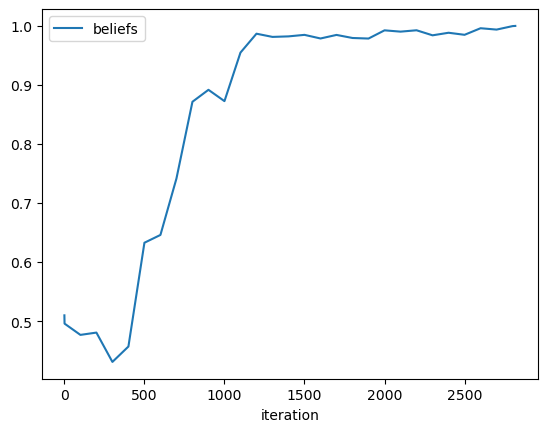

In [589]:
x = Processor("data")
x.get()
x.beliefs[0].groupby("iteration").mean().plot()

# TESTING

creating groups

In [ ]:
# Function to create a complete DGL graph with random groups
def create_complete_graph_with_groups(size):
    # 1. Create a complete graph using NetworkX
    nx_graph = nx.complete_graph(size)
    
    # 2. Convert NetworkX graph to DGL graph
    dgl_graph = dgl.from_networkx(nx_graph)
    
    groups = 3

    # Shuffle the nodes
    nodes = list(range(size))
 

    # Calculate nodes per group and the remainder
    nodes_per_group = size // groups
    remainder = size % groups
    
    group_tensor = torch.zeros(size, dtype=torch.int64)
    node_idx = 0
    
    for group_idx in range(groups):
        group_size = nodes_per_group + (1 if group_idx < remainder else 0)
        group_nodes = nodes[node_idx:node_idx + group_size]
        group_tensor[group_nodes] = group_idx
        node_idx += group_size

    # Add the group assignments to the graph
    dgl_graph.ndata['group'] = group_tensor

    # Assign arbitrary values to each node
    arbitrary_values = torch.rand(size)  # Replace with any arbitrary values
    dgl_graph.ndata['value'] = arbitrary_values

    return dgl_graph

# Example usage
size = 9  # Number of nodes in the graph
dgl_graph = create_complete_graph_with_groups(size)

# Check node features
print(dgl_graph.ndata)

In [ ]:
# Dynamically create masks for each group
group_masks = {}
groups_test = 3
for group in range(groups_test):
    group_masks[group] = (dgl_graph.ndata['group'] == group)

# Check masks
for group in group_masks:
    print(f"Mask for group {group}: {group_masks[group]}")

In [ ]:
# Extract masks for nodes by group
group_0_mask = (dgl_graph.ndata['group'] == 0)
group_1_mask = (dgl_graph.ndata['group'] == 1)

# Check 
print(group_0_mask)

In [ ]:
# Extract values for each group
values_group_0 = dgl_graph.ndata['value'][group_0_mask]
values_group_1 = dgl_graph.ndata['value'][group_1_mask]

print("Values for group 0 nodes:", values_group_0)
print("Values for group 1 nodes:", values_group_1)

# Perform some arbitrary computation, for example, summing the values in each group
sum_values_group_0 = values_group_0.sum().item()
sum_values_group_1 = values_group_1.sum().item()

print(f"Sum of values for group 0: {sum_values_group_0}")
print(f"Sum of values for group 1: {sum_values_group_1}")

In [ ]:
def complete_grouped_(size, groups, selfloop=True):
    """
    Returns a grouped, undirected fully-connected graph.
    """
    # Check network size
    assert size > 1
    # Check group size
    assert groups > 0 and groups <= size
    # Get graph from networkx
    graph = dgl.from_networkx(nx.complete_graph(size))

    # Shuffle the nodes
    nodes = list(range(size))
    random.shuffle(nodes)
    
    # Calculate nodes per group and the remainder
    nodes_per_group = size // groups
    remainder = size % groups
    
    group_tensor = torch.zeros(size, dtype=torch.int64)
    node_idx = 0
    
    for group_idx in range(groups):
        group_size = nodes_per_group + (1 if group_idx < remainder else 0)
        group_nodes = nodes[node_idx:node_idx + group_size]
        group_tensor[group_nodes] = group_idx
        node_idx += group_size
    
    # Add group information as a node feature
    graph.ndata['group'] = group_tensor


    return graph

In [394]:
class JTest(ops.core.PolyGraphOp):
    """

    """

    def __init__(self, graph, params):
        super().__init__(graph, params)

        # Multiplier that captures how quickly agents become uncertain about
        # the evidence of their peers as their beliefs diverge.
        self.mistrust = params.mistrust

        # Whether to discount evidence with unti-updating or not
        self.antiupdating = params.antiupdating

    def filterfn(self):
        """
        # Filters out edges whose source has no evidence to report
        """

        def function(edges):
            return torch.gt(edges.src["payoffs"][:, 1], 0.0)

        return function

    def messagefn(self):
        """
        Message function
        """

        def function(edges):
            return {"payoffs": edges.src["payoffs"], "beliefs": edges.src["beliefs"]}

        return function

    def _distancefn(self, delta):
        """
        Distance function
        """
        return delta * self.mistrust

    def reducefn(self):
        """
        Reduce function
        """

        def function(nodes):
            # Log probability of successful trials
            logits = nodes.data["logits"]
            # Prior, P(H) (aka. belief)
            prior = nodes.data["beliefs"]

            attrs = vars(nodes)
            #print(', '.join("%s: %s" % item for item in attrs.items()))
            # Number of nodes and number of neighbours per node (incoming messages)

            # print(nodes.mailbox["payoffs"])
            # print("break")
            # print(nodes.mailbox["payoffs"][:, :, 1])
            _, neighbours = nodes.mailbox["beliefs"].shape
        
            for i in range(neighbours):
                # A node receives evidence E from its i-th neighbour, say Jill,
                # denoting the number of successful trials and the total number
                # of trials she observed
                mailboxf = nodes.mailbox["payoffs"]
                values = nodes.mailbox["payoffs"][:, i, 0]
                trials = nodes.mailbox["payoffs"][:, i, 1]
                print(f"The neighbor is: {i} The values are: {values} The mailbox is: {mailboxf}")

                # Evidence, E
                evidence = math.Evidence(logits, values, trials)

                # The difference in belief between an agent
                # and its i-th neighbour
                delta = torch.abs(prior - nodes.mailbox["beliefs"][:, i])
            
                # Compute belief that the evidence E is real, P(E)(d)
                if self.antiupdating:
                    certainty = torch.max(
                        1.0
                        - self._distancefn(delta)
                        * (1.0 - math.marginal(prior, evidence)),
                        torch.zeros((len(nodes),)),
                    )
                else:
                    # Consider an agent u and one of its neighbours, v. As
                    # beliefs between u and v diverge (delta towards 1),
                    # agent u simply ignores the evidence of agent v.
                    #
                    # If delta becomes 1, uncertainty ~ marginal. In other
                    # words, agent u's belief remains unchanged in light of
                    # agent v's evidence.
                    #
                    # The multiplier simply determines how far apart beliefs
                    # have to become before agent u begins to ignore the
                    # evidence of its neighbour, v (since delta never becomes 1)
                    certainty = 1.0 - torch.min(
                        torch.ones((len(nodes),)), self._distancefn(delta)
                    ) * (1.0 - math.marginal(prior, evidence))

                # Compute posterior belief, in light of soft uncertainty
                posterior = math.jeffrey(prior, evidence, certainty)

                # Consider next neighbour
                prior = posterior

            # Return posterior beliefs for each neighbour
            return {"beliefs": posterior}

        return function

In [395]:
# Delete existing data folder for results
try:
    shutil.rmtree("data")
except:
    pass

params = complete(3, seed=12345)
params.simulation.results = "data/ow"
_ = pg.simulate(params, op=JTest)

The neighbor is: 0 The values are: tensor([2., 5., 5.]) The mailbox is: tensor([[[ 2., 10.],
         [ 6., 10.],
         [ 5., 10.]],

        [[ 5., 10.],
         [ 6., 10.],
         [ 2., 10.]],

        [[ 5., 10.],
         [ 2., 10.],
         [ 6., 10.]]])
The neighbor is: 1 The values are: tensor([6., 6., 2.]) The mailbox is: tensor([[[ 2., 10.],
         [ 6., 10.],
         [ 5., 10.]],

        [[ 5., 10.],
         [ 6., 10.],
         [ 2., 10.]],

        [[ 5., 10.],
         [ 2., 10.],
         [ 6., 10.]]])
The neighbor is: 2 The values are: tensor([5., 2., 6.]) The mailbox is: tensor([[[ 2., 10.],
         [ 6., 10.],
         [ 5., 10.]],

        [[ 5., 10.],
         [ 6., 10.],
         [ 2., 10.]],

        [[ 5., 10.],
         [ 2., 10.],
         [ 6., 10.]]])
The neighbor is: 0 The values are: tensor([5., 6., 6.]) The mailbox is: tensor([[[ 5., 10.],
         [ 5., 10.],
         [ 6., 10.]],

        [[ 6., 10.],
         [ 5., 10.],
         [ 5., 10.]]